#### Imports

In [1]:
import warnings
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from typing import Annotated, Literal, TypeVar
import mne
import sys
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import scipy
import pywt
import pandas as pd

mne.set_log_level('WARNING')
mne.set_config('MNE_BROWSE_RAW_SIZE', '16,8')

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define Functions

## Get Data

#### Bonn University

In [2]:
def get_data_bonn(sets_to_read: list = ['A', 'B', 'C', 'D', 'E']):
    """
    Returns data for all specified sets from the Bonn University dataset
    Data returned is in a dictionary with set letters as keys and arrays of mne raw data

    Sets A and B are from healthy patients, while Sets C, D, and E are from epileptic patients.

    Sets C and D are seizure-free segments while set E is during a seizure.

    Each set contains 100 single-channel EEG segments of 23.6-sec duration. The EEGs were recorded at a sampling rate of 173.61 Hz with 12-bit resolution over a 10 mV range.
    """
    time_segments = 100
    time_points = 4096
    freq = 173.61

    # maps from set_letter to set_letter_alternate (for the filenames)
    sets_to_file_prefixes = {
        'A': 'Z',
        'B': 'O',
        'C': 'N',
        'D': 'F',
        'E': 'S'
    }

    raws_all_categories = {}
    for set in sets_to_read:
        if set not in sets_to_file_prefixes:
            continue

        set_letter_alternate = sets_to_file_prefixes[set]

        raws_one_set = []
        for i in range(time_segments):
            filename = f'data/bonn/SET {set}/{set_letter_alternate}{str(i+1).zfill(3)}.txt'
            z = np.loadtxt(filename)

            info = mne.create_info(
                ch_names=1,
                sfreq=freq,
                ch_types='eeg',
            )
            raw = mne.io.RawArray(
                np.reshape(z[:time_points], (1, time_points)), info)
            raws_one_set.append(raw)

        raws_all_categories[set] = raws_one_set

    return raws_all_categories

#### AHEPA

In [3]:
def get_data_ahepa(disease: Literal['F', 'A'] = 'F'):
    """
    https://openneuro.org/datasets/ds004504/versions/1.0.7
    A dataset of EEG recordings from: Alzheimer's disease, Frontotemporal dementia and Healthy subjects
    """
    raws_all_categories = {}
    # dictionary from set to 3d numpy array (time_segments, channels, time_points)

    participants = pd.read_csv('data/AHEPA/participants.tsv', sep='\t')

    for disorder in {disease, 'C'}:
        DISORDER = participants[participants['Group'] == disorder]

        raws_one_disorder = []
        for participant_id in DISORDER['participant_id']:
            # read derivatives folder for preprocessed data
            filename = f'data/AHEPA/derivatives/{participant_id}/eeg/{participant_id}_task-eyesclosed_eeg.set'
            raw = mne.io.read_raw_eeglab(filename, preload=True)
            # raw.plot()
            raws_one_disorder.append(raw)

        raws_all_categories[disorder] = raws_one_disorder

    return raws_all_categories

## Processing

#### Filtering

In [4]:
def filter_raws(raws_all_categories, notch_freq=50, low_freq=0.1, high_freq=64):
    for set in raws_all_categories:
        for i in range(len(raws_all_categories[set])):
            # if i > 0: break
            # raws_all_sets[set][i].copy().compute_psd().plot()

            # raws_all_sets[set][i].copy().plot(duration=5, n_channels=15, scalings=500)
            raws_all_categories[set][i] = raws_all_categories[set][i].notch_filter(
                freqs=notch_freq)
            raws_all_categories[set][i] = raws_all_categories[set][i].filter(
                l_freq=low_freq, h_freq=high_freq)
            # raws_all_sets[set][i].copy().compute_psd().plot();
            # raws_all_sets[set][i].copy().plot(duration=5, n_channels=15, scalings=500);
    return raws_all_categories

#### DWT

In [5]:
def discrete_wavelet_transform(raws_all_categories, channel_approach: Literal['average', 'each'] = 'average'):
    dwt_outputs_all_sets = {}

    # Loop through each set we're classifying (ex: F, C or A, B, C, D, E)
    for set in raws_all_categories:
        dwt_outputs_all_sets[set] = []

        # Loop through each recording (sub-0XX)/time segment/epoch
        for epoch in raws_all_categories[set]:
            epoch_array = epoch.get_data()

            # Loop through each channel in every epoch
            for epoch in epoch_array:
                data = epoch

                if channel_approach == 'average':
                    data = np.mean(data, axis=0)
                    data = np.reshape(data, (1, data.shape[0]))

                dwt_outputs_one_epoch = []

                # Loop through each channel in the data
                for channel in data:
                    # 1D multilevel DWT
                    delta, theta, alpha, beta, gamma = pywt.wavedec(
                        channel, wavelet='db4', level=4)
                    
                    # print(delta.shape, theta.shape, alpha.shape, beta.shape, gamma.shape)
                    
                    dwt_outputs_one_epoch.append([delta, theta, alpha, beta, gamma])
                
                dwt_outputs_all_sets[set].append(dwt_outputs_one_epoch)

                # low frequencies => high time resolution, low freq resolution
                # high frequences => low time resolution, high freq resolution

                # print(cA4.shape)  # 0.1-4 Hz   delta
                # print(cD4.shape)  # 4-8 Hz     theta
                # print(cD3.shape)  # 8-16 Hz    alpha
                # print(cD2.shape)  # 16-32 Hz   beta
                # print(cD1.shape)  # 32-64 Hz   gamma
    return dwt_outputs_all_sets

## Feature Extraction

#### Features

In [28]:
def variance(data):
    output = np.var(data)
    # print('variance_data: ', output)
    return output


def standard_deviation(data):
    """
    measures the amount of variation of a set of values
    """
    output = np.std(data)
    # print('std_data: ', output)
    return output


def kurtosis(data):
    """
    measure of the 'tailedness' of the data or outliers
    """
    # fisher = True is default, which subtracts 3 from the final value
    output = scipy.stats.kurtosis(data, fisher=False)
    # print('kurtosis output: ', output)
    return output


def nn_shannon_entropy(data):
    """
    measures the uncertainty of the data (or how surprising it is)
    """
    # squared so log is never taken of a negative number in the data
    squared = data**2
    output = np.sum(squared * np.log(squared))
    # print('entropy output: ', output)
    return output


def logarithmic_band_power(data):
    """
    """
    output = np.log(np.sum(data**2) / data.shape[0])
    # print('logarithmic band power output: ', output)
    return output


def compute_features(data):  # -> shape (#, 5)
    # print('data shape: ', data.shape)
    return np.array([
        logarithmic_band_power(data),
        standard_deviation(data),
        variance(data),
        kurtosis(data),
        nn_shannon_entropy(data)
    ], dtype=np.float64).T


BandType = Literal['delta', 'theta', 'alpha', 'beta', 'gamma']
FeatureType = Literal['LBP', 'Std', 'Var', 'Kur', 'SE']


def graph_feature_vectors(
    dataset: Literal['BONN', 'AHEPA'],
    feature_vectors_all_sets: dict[str, np.ndarray],
    band_x: BandType,
    band_y: BandType,
    feature: FeatureType,

    features,
):  
    bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

    sets_to_graph = ['F']

    channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
    # colors_to_regions = {
    #     'black': 'Pre-frontal',
    #     'red': 'Frontal',
    #     'green': 'Temporal',
    #     'yellow': 'Central',
    #     'blue': 'Parietal',
    #     'purple': 'Occipital',
    # }
    color_nums_to_regions = {
        0: 'Pre-frontal',
        1: 'Frontal',
        2: 'Temporal',
        3: 'Central',
        4: 'Parietal',
        5: 'Occipital',
    }
    channels_to_regions = {
        'Fp1': 'Pre-frontal',
        'Fp2': 'Pre-frontal',
        'F7': 'Frontal',
        'F3': 'Frontal',
        'Fz': 'Frontal',
        'F4': 'Frontal',
        'F8': 'Frontal',
        'T3': 'Temporal',
        'C3': 'Central',
        'Cz': 'Central',
        'C4': 'Central',
        'T4': 'Temporal',
        'T5': 'Temporal',
        'P3': 'Parietal',
        'Pz': 'Parietal',
        'P4': 'Parietal',
        'T6': 'Temporal',
        'O1': 'Occipital',
        'O2': 'Occipital',
    }
    # regions_to_colors = {
    #     'Pre-frontal': 'black',
    #     'Frontal': 'red',
    #     'Temporal': 'green',
    #     'Central': 'yellow',
    #     'Parietal': 'blue',
    #     'Occipital': 'purple',
    # }
    regions_to_color_nums = {
        'Pre-frontal': 0,
        'Frontal': 1,
        'Temporal': 2,
        'Central': 3,
        'Parietal': 4,
        'Occipital': 5,
    }

    # if dataset == 'AHEPA':
    #     color_mapping = {
    #         'F': 'blue',
    #         'C': 'green',
    #     }
    # else:
    #     color_mapping = {
    #         'A': 'green',
    #         'B': 'green',
    #         'C': 'blue',
    #         'D': 'blue',
    #         'E': 'blue',
    #     }

    x = []
    y = []
    c = []
    
    # Loop through each available set
    for set in feature_vectors_all_sets:
        if set not in sets_to_graph:
            continue

        # Loop through each epoch
        for epoch in feature_vectors_all_sets[set]:  # epoch has shape (# channels, # bands, # features)

            # Loop through each channel
            for i, channel in enumerate(epoch):
                region = channels_to_regions[channels[i]]

                x.append(channel[bands.index(band_x)][features.index(feature)])
                y.append(channel[bands.index(band_y)][features.index(feature)])

                c.append(regions_to_color_nums[region])

                # plt.scatter(x, y, color=regions_to_colors[region], s=4, label=region)
                # plt.scatter(x, y, color=color_mapping[set], s=4)

    df = pd.DataFrame({
        'x': x,
        'y': y,
        'colors': c
    })

    cmap = plt.cm.viridis
    norm = plt.Normalize(df['colors'].values.min(), df['colors'].values.max())

    for i, dff in df.groupby("colors"):
        plt.scatter(dff['x'], dff['y'], s=10, c=cmap(norm(dff['colors'])), 
                    edgecolors='none', label=color_nums_to_regions[i])

    plt.legend()
    # plt.title(f'{band_x} vs {band_y} {feature} for {dataset}')
    plt.title(f'Comparison of {band_x} vs {band_y} {feature} across Brain Regions (FTD patients)')
    plt.xlabel(f'{band_x} {feature}')
    plt.ylabel(f'{band_y} {feature}')
    plt.show()

#### Feature Vector

In [13]:
def get_feature_vectors_all_sets(dwt_outputs_all_sets):
    # TODO: ipmlement features
    feature_vectors_all_sets: dict[str, np.ndarray] = {}

    # Loop through each set we're classifying (ex: F, C or A, B, C, D, E)
    for set in dwt_outputs_all_sets:
        feature_vectors_all_sets[set] = []

        # Loop through each recording (sub-0XX)/time segment
        for recording in dwt_outputs_all_sets[set]:

            feature_vectors_one_recording = []

            # Loop through each channel in the data
            for channel in recording:
                feature_vectors_one_recording.append(np.vstack([compute_features(band) for band in channel]))
            
            feature_vectors_all_sets[set].append(np.array(feature_vectors_one_recording))

        feature_vectors_all_sets[set] = np.array(feature_vectors_all_sets[set])

    return feature_vectors_all_sets

## Classification

In [8]:
def k_fold_cross_validation(X, y, k_folds=10):
    """
    k-fold cross validation
    inputs: X, y, k_folds
    """
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
    kf = KFold(n_splits=k_folds, random_state=1, shuffle=True)
    kf.get_n_splits(X)
    accuracy = 0
    accuracies = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        accuracy_this_fold = knn(X_train, y_train, X_test, y_test, k=5)
        accuracy += accuracy_this_fold
        accuracies.append(accuracy_this_fold)
    print('Accuracies: ', accuracies)
    return accuracy / k_folds


def knn(X_train, y_train, X_test, y_test, k):
    """
    normal knn classifier
    determines the best k value and returns the best accuracy
    inputs: train test split
    """
    # https://www.tutorialspoint.com/scikit_learn/scikit_learn_kneighbors_classifier.htm
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    # confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    return metrics.accuracy_score(y_test, y_pred)

# Run

In [9]:
# ------------------ CONSTANTS ------------------
# Which dataset to use
dataset: Literal['AHEPA', 'BONN'] = 'AHEPA'
disease: Literal['F', 'A'] = 'F'

# Whether to use the average of all channels or each channel individually when computing DWT
channel_approach: Literal['average', 'each'] = 'each'


# ------------------ AHEPA ------------------
if dataset == 'AHEPA':
    raws_all_categories = get_data_ahepa(disease=disease)

# ------------------ BONN ------------------
if dataset == 'BONN':
    raws_all_categories = get_data_bonn()
    raws_all_categories = filter_raws(
        raws_all_categories, notch_freq=50, low_freq=0.1, high_freq=64)

# raws_all_categories['C'][0].plot();

In [10]:
# Segment the data into 50 second epochs, or don't segment at all for BONN

if dataset == 'AHEPA':
    segment_length = 50
else:
    segment_length = 23

for set in raws_all_categories:
    for i, raw in enumerate(raws_all_categories[set]):
        epochs = mne.make_fixed_length_epochs(raw, duration=segment_length)
        raws_all_categories[set][i] = epochs

In [11]:
# Apply Discrete Wavelet Transform to the data

dwt_outputs_all_sets = discrete_wavelet_transform(raws_all_categories, channel_approach=channel_approach)

print(len(dwt_outputs_all_sets['C']))          # num recordings
print(len(dwt_outputs_all_sets['C'][0]))       # num channels
print(len(dwt_outputs_all_sets['C'][0][0]))    # num freq bands
print(len(dwt_outputs_all_sets['C'][0][0][0])) # num data points

468
19
5
1569


In [14]:
features = ['LBP', 'Std', 'Var', 'Kur', 'SE']

feature_vectors_all_sets = get_feature_vectors_all_sets(dwt_outputs_all_sets)  # TODO: add features arg in here

print(feature_vectors_all_sets['C'].shape)          # num recordings, num channels, num freq bands, num features

(468, 19, 5, 5)


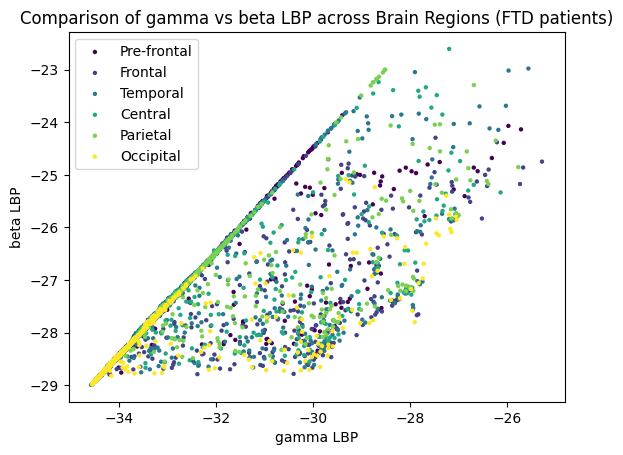

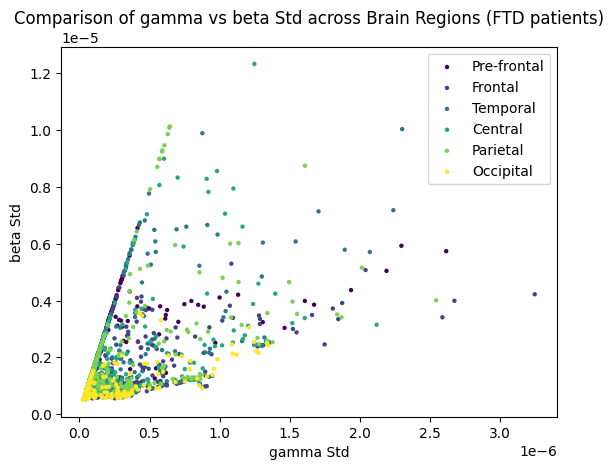

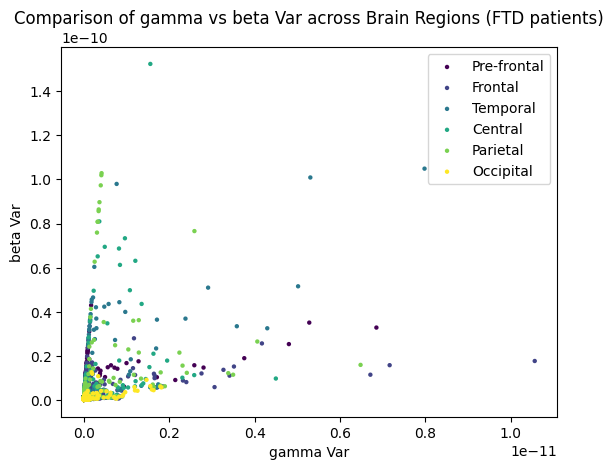

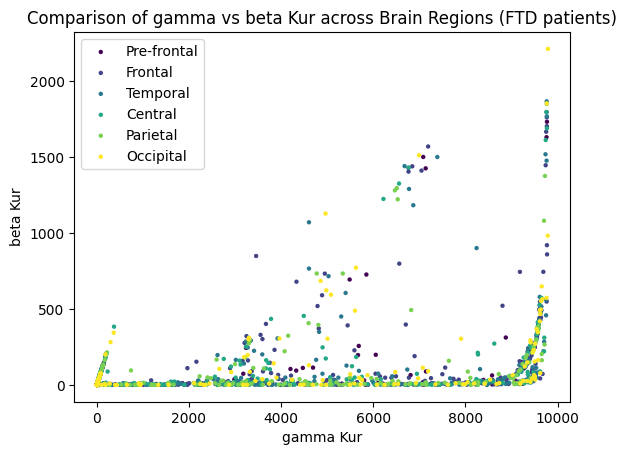

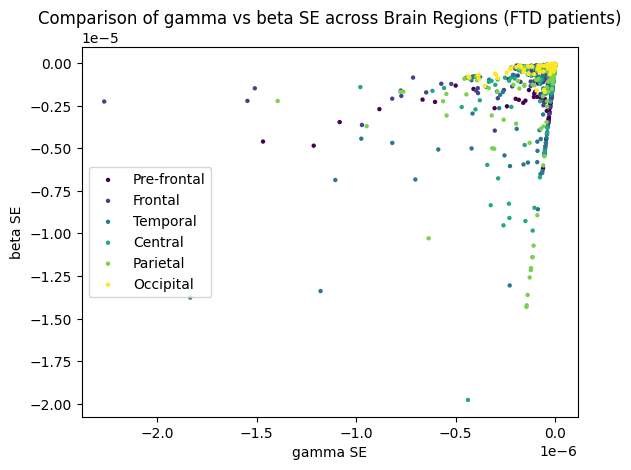

In [36]:
# Graph features & their individual impact?

for feature in features:
    graph_feature_vectors(
        dataset,
        feature_vectors_all_sets,
        band_x='gamma',
        band_y='beta',
        feature=feature,
        features=features
    )

In [ ]:
# Convert feature_vectors_all_sets to workable shape for classification (# recordings, features)
# (# recordings, # megafeatures) or (# recordings, # channels, # features)  (which one would be better?)

for set in feature_vectors_all_sets:

    epochs = []
    for i, epoch in enumerate(feature_vectors_all_sets[set]):
        epochs.append(epoch.flatten())

    feature_vectors_all_sets[set] = np.array(epochs)

print(feature_vectors_all_sets['C'].shape)

In [ ]:
# Convert to pandas dataframe

if dataset == 'AHEPA':
    # ------------------ AHEPA ------------------
    set_mapping = {
        disease: 1,
        'C': 0
    }  # 1 for Alzheimer's, 0 for healthy

    if channel_approach == 'each':
        channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
    else:
        channels = ['Avg']
else:
    # ------------------ BONN ------------------
    set_mapping = {
        'A': 0,
        'B': 0,
        'C': 1,
        'D': 1,
        'E': 1
    }  # 1 for epileptic, 0 for healthy

    channels = ['C']

data = pd.DataFrame(np.vstack([feature_vectors_all_sets[set] for set in feature_vectors_all_sets]))
data.columns = [f'{channel}_{band}_{feature}' for channel in channels for band in ['A4', 'D4', 'D3', 'D2', 'D1'] for feature in ['LBP', 'Std', 'Var', 'Kur', 'SE']]
data['Set'] = sum([[set_mapping[set]] * len(feature_vectors_all_sets[set]) for set in feature_vectors_all_sets], [])

X = data.drop('Set', axis=1)
y = data['Set'].values

print(X.shape, y.shape)


In [ ]:
k_fold_accuracy = k_fold_cross_validation(X.values, y, k_folds=10)
print('Average of k folds:', k_fold_accuracy)


# FTD - multi-channel with all 5 features
# Accuracies:  [0.7974683544303798, 0.7721518987341772, 0.7341772151898734, 0.7341772151898734, 0.759493670886076, 0.6962025316455697, 0.7974683544303798, 0.7848101265822784, 0.6962025316455697, 0.6923076923076923]
# Average of k folds: 0.746445959104187

# FTD - average channel with all 5 features
# Accuracies:  [0.6329113924050633, 0.6329113924050633, 0.4936708860759494, 0.7215189873417721, 0.569620253164557, 0.569620253164557, 0.6329113924050633, 0.5949367088607594, 0.5569620253164557, 0.6923076923076923]
# Average of k folds: 0.6097370983446933